# FigS3: Screened Coulomb potential

In [1]:
import kwant
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as la
import scipy.sparse as sp
import scipy.sparse.linalg as sla
from amsc import (
    impurity_system,
    bulk_amsc_system,
    generate_intial_Delta,
    setup_gaussian_impurities,
    setup_spin_impurities,
    setup_Coulomb_impurities,
)
from plot_tools import add_tl_label, complex_plot
from scipy.interpolate import RegularGridInterpolator
from tqdm.notebook import tqdm
from pauli import *
from qm_tools import thermal_broadening, sparse_diag, sort_eigensystem

In [2]:
# eigsh = sla.eigsh
eigsh = sparse_diag  # MUMPS

In [3]:
plt.style.use("../plot_style.mplstyle")

In [4]:
periodic_bc = True

Nx = 81
Ny = 81

x_ax = np.linspace(-(Nx // 2), (Nx // 2), Nx)
y_ax = np.linspace(-(Ny // 2), (Ny // 2), Ny)
x, y = np.meshgrid(x_ax, y_ax)

t = 5.0
t_so = 0.0 * t
t_am = 0.25 * t

mu = 2.5
hz0 = 1e-6
hx0 = 0
hy0 = 0

## Initial value for Delta (will be used to determine g)
Delta_init = 1

In [5]:
vortex_positions = []
windings = []
l_core = 0  # l_core is the decay length of the order parameter (in a vortex that is the coherence length)

Delta, theta = generate_intial_Delta(
    x=x,
    y=y,
    Delta_init=Delta_init,
    vortex_positions=vortex_positions,
    windings=windings,
    l_core=l_core,
)

In [6]:
# Impurituy positions
impurity_positions = [(0, 0)]  # , (-10, 0)]
impurity_sizes = [3]  # Sizes
impurity_eccentricities = [0.0]  # Eccentricity
impurity_orientation = [0.0]  # Orientation


V_imp = [-10]  # Impurity potential (negative = attractive)
hx_imp = [0.0]  # Impurity field
hy_imp = [0.0]  # Impurity field
hz_imp = [0.0]  # Impurity field

hx, hy, hz = setup_spin_impurities(
    x=x,
    y=y,
    hx0=hx0,
    hy0=hy0,
    hz0=hz0,
    impurity_sizes=impurity_sizes,
    impurity_positions=impurity_positions,
    impurity_eccentricities=impurity_eccentricities,
    impurity_orientations=impurity_orientation,
    hx_imp=hx_imp,
    hy_imp=hy_imp,
    hz_imp=hz_imp,
)

In [7]:
N = 128

## V_0

In [8]:
Vss = np.linspace(-10, -90, 33)
wss = np.zeros((33, N))

vss = np.zeros((33, 4 * Nx**2, N), dtype=complex)

for i, Vs in tqdm(enumerate(Vss), total=len(Vss)):

    V = setup_Coulomb_impurities(
        x=x,
        y=y,
        mu=mu,
        impurity_positions=impurity_positions,
        V_imp=[Vs],
        screening_length=4,
    )

    syst, lat = bulk_amsc_system(
        Nx=Nx,
        Ny=Ny,
        t=t,
        t_so=t_so,
        t_am=t_am,
        V=V,
        Delta=Delta,
        theta=theta,
        hx=hx,
        hy=hy,
        hz=hz,
        periodic_bc=periodic_bc,
    )

    fsyst = syst.finalized()

    ws, vs = eigsh(fsyst.hamiltonian_submatrix(sparse=True), k=N, sigma=0)

    wss[i] = ws
    vss[i] = vs

wss, vss = sort_eigensystem(wss, vss)

  0%|          | 0/33 [00:00<?, ?it/s]

KeyboardInterrupt: 

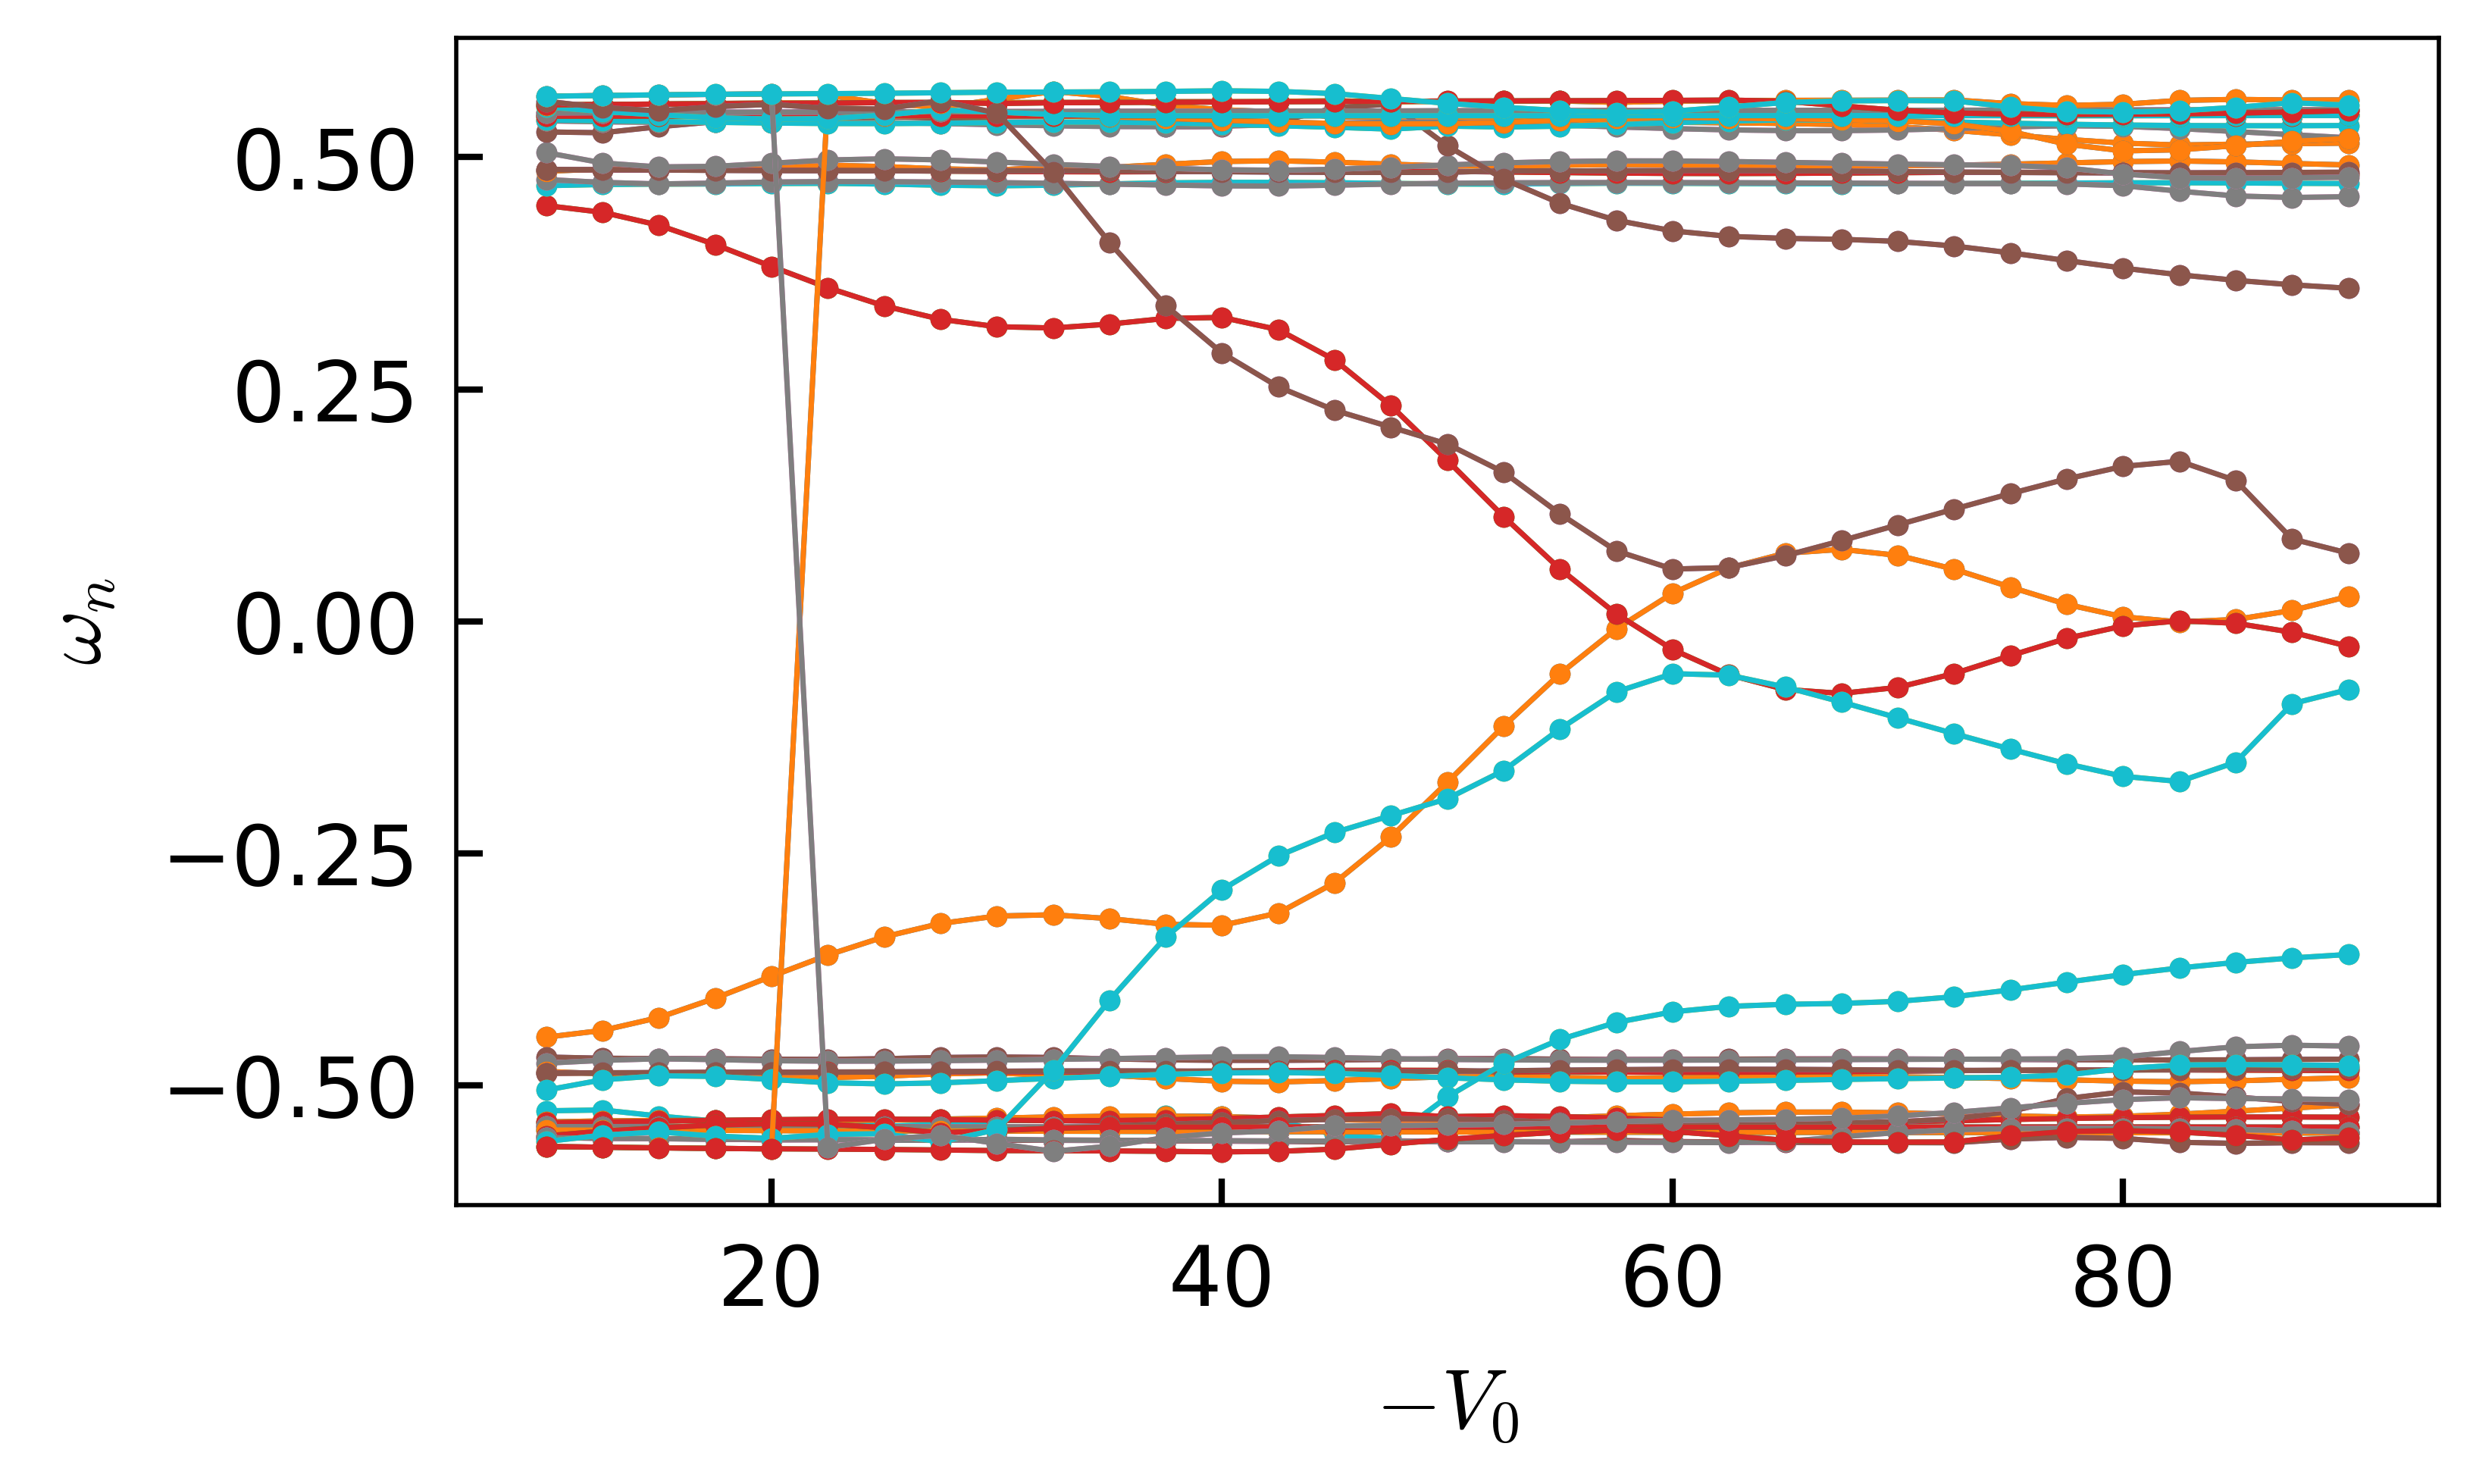

In [ ]:
fig, ax = plt.subplots()
ax.plot(-Vss, wss[:, :])
plt.xlabel(r"$-V_0$")
plt.ylabel(r"$\omega_n$")
fig.savefig("./imgs/FigS3.svg")

## w_imp

In [ ]:
sizes = np.linspace(1, 6, 21)
wss = np.zeros((21, N))
vss = np.zeros((21, 4 * Nx**2, N), dtype=complex)


for i, size in tqdm(enumerate(sizes), total=len(sizes)):

    V, hx, hy, hz = setup_gaussian_impurities(
        x=x,
        y=y,
        mu=mu,
        hx0=hx0,
        hy0=hy0,
        hz0=hz0,
        impurity_sizes=[size],
        impurity_positions=impurity_positions,
        impurity_eccentricities=impurity_eccentricities,
        impurity_orientations=impurity_orientation,
        V_imp=[-16],
        hx_imp=hx_imp,
        hy_imp=hy_imp,
        hz_imp=hz_imp,
    )

    syst, lat = bulk_amsc_system(
        Nx=Nx,
        Ny=Ny,
        t=t,
        t_so=t_so,
        t_am=t_am,
        V=V,
        Delta=Delta,
        theta=theta,
        hx=hx,
        hy=hy,
        hz=hz,
        periodic_bc=periodic_bc,
    )

    fsyst = syst.finalized()

    ws, vs = eigsh(fsyst.hamiltonian_submatrix(sparse=True), k=N, sigma=0)

    wss[i] = ws
    vss[i] = vs

  0%|          | 0/21 [00:00<?, ?it/s]

Text(0.5, 0, '$S$')

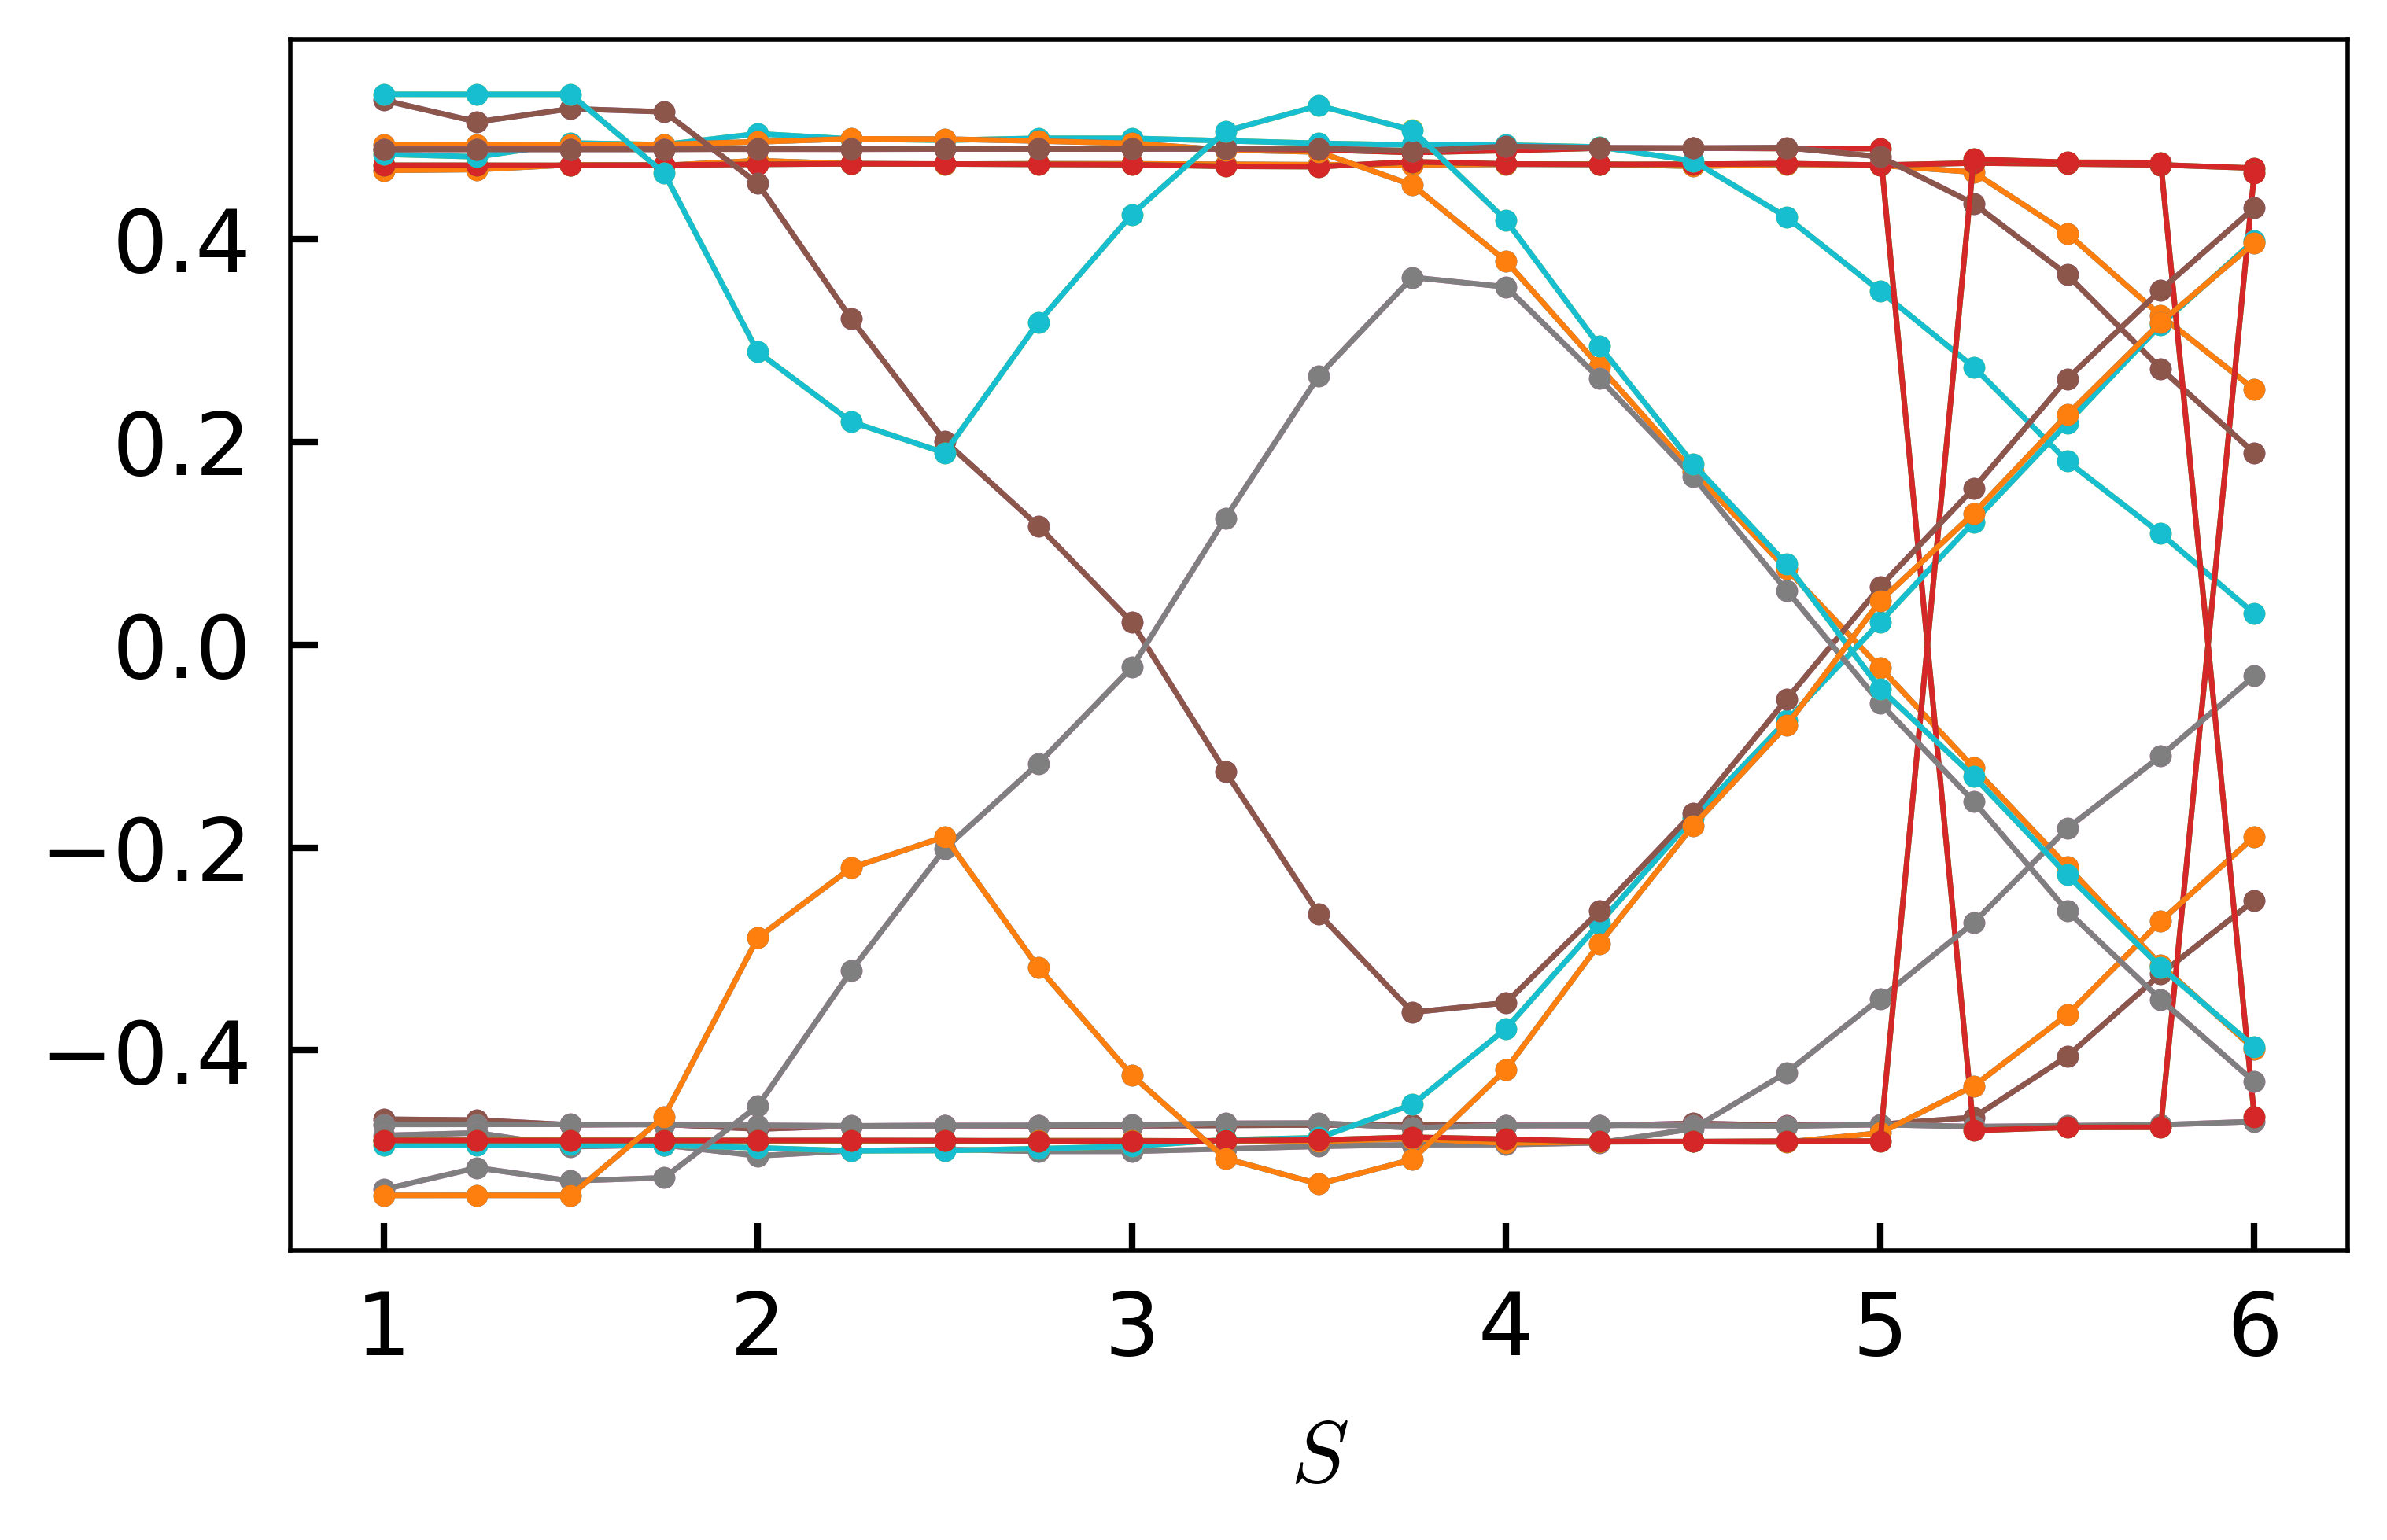

In [ ]:
wss, vss = sort_eigensystem(wss, vss)
plt.plot(sizes, wss)
plt.xlabel(r"$w_\mathrm{imp}$")